In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch import optim
from pytorch_lightning.metrics import Accuracy, Metric, F1, Precision, Recall
import PIL
from PIL import Image
import glob
import time

In [ ]:
!pip install torch-lr-finder
from torch_lr_finder import LRFinder

##### Original Paper with data
https://www.researchgate.net/profile/Harshadkumar_Prajapati/publication/318437440_Detection_and_classification_of_rice_plant_diseases/links/5b861c9192851c1e1238e7a5/Detection-and-classification-of-rice-plant-diseases.pdf?origin=publication_detail

##### Metrics Library Pytorch and amazing data Loading tool glob.glob
https://pytorch-lightning.readthedocs.io/en/latest/metrics.html
https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

#### Code to implement Learning Rate Finder
https://pypi.org/project/pytorch-lr-finder/
https://github.com/davidtvs/pytorch-lr-finder


# To Do

* Read and add on to previous work.

##### Important Links
https://paperswithcode.com/

* Torchvision Models

https://pytorch.org/hub/facebookresearch_WSL-Images_resnext/

https://pytorch.org/docs/stable/torchvision/models.html

https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling


## Load in Data For Convolution Neural Network

In [2]:
def create_dataframe(image_file_paths):
    
    assert len(image_file_paths) == 120
    
    classes = ["Bacterial leaf blight", "Brown spot", "Leaf smut"]
    dataframe = pd.DataFrame(image_file_paths, columns = ["image_path"])
    dataframe["label"] = dataframe.apply(lambda row: classes.index(row["image_path"].rsplit('/', 2)[-2]), axis = 1)
    
    return dataframe

#Use glob glob to find pattern in file types to get list of all image paths
image_file_paths = glob.glob("../input/rice-leaf-disease-dataset/rice_leaf_diseases/*/*.JPG")
image_file_paths.extend(glob.glob("../input/rice-leaf-disease-dataset/rice_leaf_diseases/*/*.jpg"))
rice_leaf_df = create_dataframe(image_file_paths)

#checking the dataframe
rand_index = np.random.randint(0, 119)
print(rice_leaf_df["image_path"][rand_index])
print(rice_leaf_df["label"][rand_index])
print(rand_index)

../input/rice-leaf-disease-dataset/rice_leaf_diseases/Bacterial leaf blight/DSC_0370.jpg
0
90


In [3]:
class RiceLeafDataset():
    def __init__(self, df, transform):
        
        self.transform = transform
        self.df = df
        
        
    def __getitem__(self, index):
        
        image_path = self.df["image_path"].iloc[index]
        image = Image.open(image_path).convert("RGB")
        label = self.df["label"].iloc[index]
        
        if self.transform != None:
            image = self.transform(image)
            
        return (image, label)
    
    
    def __len__(self):
        
        return len(self.df)
    

In [4]:
#Since transforms work well with train_compose
#Can play with center crop or random crop
train_transform = transforms.Compose([
    
    transforms.Resize(255),
    transforms.RandomCrop(224),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

entire_df = rice_leaf_df.sample(frac=1).reset_index(drop=True)
train_df = entire_df.iloc[:(int(len(entire_df) * 0.8))]
test_df = entire_df.iloc[(int(len(entire_df) * 0.8)):]

train_dataset = RiceLeafDataset(train_df, train_transform)
test_dataset = RiceLeafDataset(test_df, test_transform)


In [5]:
#Even if test_loader has less than batch_size it still works. 
batch_size=32
shuffle_dataset = True
random_seed= 42

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers = 0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle = False, num_workers = 0)


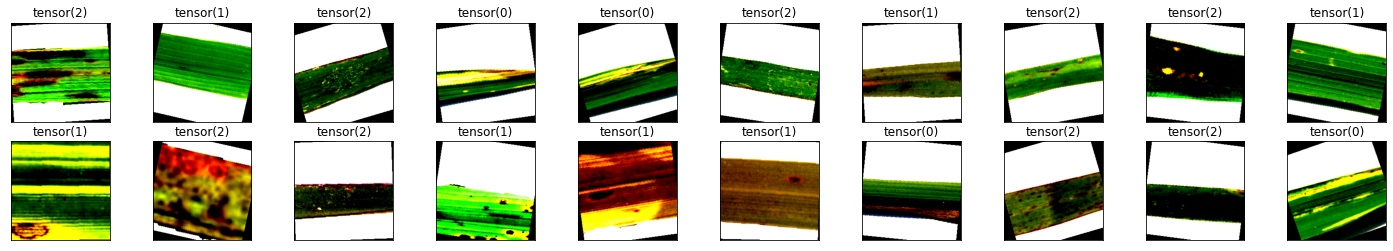

In [6]:
dateiter = iter(train_loader)
images, labels = dateiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(labels[idx])

## Load in data for sklearn in Numpy and try OpenCV image filtering

In [7]:
def preprocess_image(image, prep_for_conv = False):
    #Look at resizing image only 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    #Block the light background
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    retval, background_binary = cv2.threshold(gray_image, 210, 255, cv2.THRESH_BINARY_INV)
    image[background_binary == 0] = [0, 0, 0]
    
    #To do: Block the dark shadow
    
    if prep_for_conv:
        
        image = image.reshape(1, 3, image.shape[0], image.shape[1])
        image = np.float32((image - np.mean(image)) / np.std(image))
        image = torch.from_numpy(image)
        
        assert image.size() == torch.Size([1, 3, 224, 224])
        

    return image

In [ ]:
## A loading function
## Build a class
def load_images_from_folder(folder_path_list, prep = False):
    classes = ["Bacterial leaf blight", "Brown spot", "Leaf smut"]
    images = list()
    labels = list()
    image_paths = list()
    for folder_path in folder_path_list:
        label = classes.index(folder_path.rsplit ('/', 1)[-1])
        for filename in os.listdir(folder_path):
            img = cv2.imread(os.path.join(folder_path,filename))
            image_paths.append(os.path.join(folder_path,filename))
            if img is not None:
                preprocessed_img = preprocess_image(img, prep_for_conv = prep)
                images.append(preprocessed_img)
                labels.append(label)
                
    if prep:
        
        labels = torch.LongTensor(labels)
        return images, labels, image_paths
            
    return np.asarray(images), np.asarray(labels), image_paths

In [ ]:
images, labels, image_paths = load_images_from_folder(["../input/rice-leaf-disease-dataset/rice_leaf_diseases/Bacterial leaf blight",
                                        "../input/rice-leaf-disease-dataset/rice_leaf_diseases/Brown spot",
                                        "../input/rice-leaf-disease-dataset/rice_leaf_diseases/Leaf smut"])

In [ ]:
num = np.random.randint(0, 119)
plt.imshow(images[num])
print(labels[num])
print(image_paths[num])
print(images[num].shape)
print(num)

In [ ]:
state = np.random.randint(0, 100)
print(state)
leafs_train, leafs_test, labels_train, labels_test = train_test_split(images, labels, test_size = 0.25, random_state = state)  
print(leafs_train.shape)
print(leafs_test.shape)
print(labels_train.shape)
print(labels_test.shape)
flat_leafs_train = leafs_train.reshape(leafs_train.shape[0], -1)
flat_leafs_test = leafs_test.reshape(leafs_test.shape[0], -1)
print(flat_leafs_train.shape)
print(flat_leafs_test.shape)

### Sklearn Models:

#### Base Prob: 33.3 % for 3 different classes
#### Classification task (From hypothesized worst to best affect on base prob)
* Naive Bayes Model - Model did alright however not fully reliable
* SVM Model
 * Without Standard Scaling the SVM performed 27% better than random on a random state of data for about 60% accuracy for 3 classes.
 * Therefore the model is an improvement but not the improvement we need.

In [ ]:
def model_scorer(y_true, y_pred):
    
    print(accuracy_score(y_true, y_pred) * 100, "%")
    print(recall_score(y_true, y_pred, average = None) * 100)
    print(precision_score(y_true, y_pred, average = None) * 100)
    print(f1_score(y_true, y_pred, average = None) * 100)
    num_correct = len(np.where(y_true == y_pred)[0])
    print("Number Correct: {}".format(num_correct))
    print("Number Wrong: {}".format(len(y_true) - num_correct))
          

In [ ]:
gaussian_NB = GaussianNB()
gaussian_NB_fit = gaussian_NB.fit(flat_leafs_train, labels_train)
gaussian_pred = gaussian_NB_fit.predict(flat_leafs_test)

model_scorer(labels_test, gaussian_pred)

In [ ]:
#Standard Scaler which is good for scaling data and destroying the sparsness of the data
scaler = StandardScaler()
scaled_flat_leafs_train = scaler.fit_transform(flat_leafs_train)
scaled_flat_leafs_test = scaler.fit_transform(flat_leafs_test)

#Lets train with a base Support Vector Machine
SVM_class = SVC(kernel = "rbf")
svm_fit = SVM_class.fit(scaled_flat_leafs_train, labels_train)
svm_pred = svm_fit.predict(scaled_flat_leafs_test)

model_scorer(labels_test, svm_pred)

## Start Building Neural Networks

In [8]:
class Mini(nn.Module):
    
    def __init__(self):
        super(Mini, self).__init__()
        
        self.convolutions = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64))
            
        self.fc1 = nn.Linear(56 * 56 * 64, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 3)
        
        self.dropout = nn.Dropout(0.4)
            
    def forward(self, image):
        
        image = self.convolutions(image)
        x = image.view(image.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [9]:
def create_conv_block(inp, out, kernel_size, small_max_pool = True):
        
        if small_max_pool:
            max_pool_kernel = 2
            max_pool_stride = 2
        else:
            max_pool_kernel = 4
            max_pool_stride = 4
            
        if kernel_size == 3:
            pad = 1
        elif kernel_size == 5:
            pad = 2
        else:
            pad = 0
        
        sequence_inputs = nn.Sequential(
            nn.Conv2d(inp, out, kernel_size, padding = pad),
            nn.ReLU(),
            nn.BatchNorm2d(out),
            nn.Conv2d(out, out, kernel_size, padding = pad),
            nn.ReLU(),
            nn.MaxPool2d(max_pool_kernel, max_pool_stride),
            nn.BatchNorm2d(out))
            
        
        return sequence_inputs

    
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block_1 = create_conv_block(3, 32, 5, small_max_pool = False)
        self.conv_block_2 = create_conv_block(32, 64, 3)
        self.conv_block_3 = create_conv_block(64, 128, 3)
        
        self.fc1 = nn.Linear(14 * 14 * 128, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 3)
        
        self.dropout = nn.Dropout(0.4)
    
    def forward(self, image):
        
        image = self.conv_block_1(image)
        image = self.conv_block_2(image)
        image = self.conv_block_3(image)
        
        x = image.view(image.size(0), -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x
    

In [10]:
net = Net()
mini = Mini()

In [11]:
def train(net, epochs, train_loader, test_loader, lr, criterion, device, weight_decay = 0):
    
    optimizer = optim.Adam(net.parameters(), lr = lr, weight_decay = weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader) * epochs)
    
    net.to(device)
    print("Device: {}".format(device))
    start_time = time.time()
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = 0
        test_loss = 0
        
        for batch_idx, (image, label) in enumerate(train_loader):
            
            if device == torch.device("cuda"):
                image = image.cuda()
                label = label.cuda()
                
            
            optimizer.zero_grad()
            output = net(image)
            train_accuracy(output, label)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        scheduler.step()
        net.eval()
        with torch.no_grad(): 
            
            for image, label in test_loader:
            
                if device == torch.device("cuda"):
                    image = image.cuda()
                    label = label.cuda()
            
                output = net(image)
                loss = criterion(output, label)
                test_loss += loss.item()
                test_accuracy(output, label)
                if epoch == (epochs - 1):
                    test_recall(output, label)
                    test_prec(output, label)
                    test_f1(output, label)
        
        net.train()
        total_test_accuracy = test_accuracy.compute()
        total_train_accuracy = train_accuracy.compute()
        final_recall = test_recall.compute()
        final_precision = test_prec.compute()
        final_f1 = test_f1.compute()
        
        print("Epoch: {}".format(epoch + 1))
        print("Train Loss: {:0.2f} |||| Train Accuracy {:0.2f}%".format(train_loss, total_train_accuracy * 100))
        print("Test Loss: {:0.2f} |||| Test Accuracy {:0.2f}%".format(test_loss, total_test_accuracy * 100))
        for param_group in optimizer.param_groups:
            print("Learning Rate {:0.8f}".format(param_group["lr"]))

            
        if epoch == (epochs - 1):
            print("Final Test Recall Score: {:0.2f}%".format(final_recall * 100))
            print("Final Test Precision Score: {:0.2f}%".format(final_precision * 100))
            print("Final Test F1 Score {:0.2f}%".format(final_f1 * 100))
            print("Total Time of Execution: {:0.2f} seconds".format(time.time() - start_time))
        

## Training both the models without Learning Rate Finder

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# We have compute_on_step = False b/c we compute all at end just before print statements
test_accuracy = Accuracy(compute_on_step = False).to(device)
train_accuracy = Accuracy(compute_on_step = False).to(device)
test_prec = Precision(num_classes=3, compute_on_step = False).to(device)
test_recall = Recall(num_classes=3, compute_on_step = False).to(device)
test_f1 = F1(num_classes=3, compute_on_step = False).to(device)
criterion = nn.CrossEntropyLoss()


train(net, 20, train_loader, test_loader, 3e-5, criterion, device)

Device: cuda
Epoch: 1
Train Loss: 3.27 |||| Train Accuracy 40.62%
Test Loss: 1.11 |||| Test Accuracy 37.50%
Learning Rate 0.00002998
Epoch: 2
Train Loss: 3.11 |||| Train Accuracy 46.88%
Test Loss: 1.11 |||| Test Accuracy 50.00%
Learning Rate 0.00002992
Epoch: 3
Train Loss: 2.81 |||| Train Accuracy 58.33%
Test Loss: 1.11 |||| Test Accuracy 20.83%
Learning Rate 0.00002982
Epoch: 4
Train Loss: 2.77 |||| Train Accuracy 58.33%
Test Loss: 1.12 |||| Test Accuracy 20.83%
Learning Rate 0.00002967
Epoch: 5
Train Loss: 2.41 |||| Train Accuracy 73.96%
Test Loss: 1.11 |||| Test Accuracy 25.00%
Learning Rate 0.00002949
Epoch: 6
Train Loss: 2.18 |||| Train Accuracy 76.04%
Test Loss: 1.08 |||| Test Accuracy 58.33%
Learning Rate 0.00002927
Epoch: 7
Train Loss: 2.15 |||| Train Accuracy 67.71%
Test Loss: 1.03 |||| Test Accuracy 70.83%
Learning Rate 0.00002900
Epoch: 8
Train Loss: 1.88 |||| Train Accuracy 71.88%
Test Loss: 0.96 |||| Test Accuracy 66.67%
Learning Rate 0.00002870
Epoch: 9
Train Loss: 1.78 |

In [13]:
#Train network on our dataset
train(mini, 20, train_loader, test_loader, 3e-5, criterion, device)

Device: cuda
Epoch: 1
Train Loss: 3.55 |||| Train Accuracy 38.54%
Test Loss: 1.06 |||| Test Accuracy 45.83%
Learning Rate 0.00002998
Epoch: 2
Train Loss: 2.78 |||| Train Accuracy 56.25%
Test Loss: 1.04 |||| Test Accuracy 41.67%
Learning Rate 0.00002992
Epoch: 3
Train Loss: 2.76 |||| Train Accuracy 60.42%
Test Loss: 1.01 |||| Test Accuracy 41.67%
Learning Rate 0.00002982
Epoch: 4
Train Loss: 2.38 |||| Train Accuracy 65.62%
Test Loss: 0.98 |||| Test Accuracy 45.83%
Learning Rate 0.00002967
Epoch: 5
Train Loss: 2.77 |||| Train Accuracy 63.54%
Test Loss: 0.92 |||| Test Accuracy 62.50%
Learning Rate 0.00002949
Epoch: 6
Train Loss: 2.36 |||| Train Accuracy 65.62%
Test Loss: 0.86 |||| Test Accuracy 66.67%
Learning Rate 0.00002927
Epoch: 7
Train Loss: 2.32 |||| Train Accuracy 66.67%
Test Loss: 0.88 |||| Test Accuracy 50.00%
Learning Rate 0.00002900
Epoch: 8
Train Loss: 2.37 |||| Train Accuracy 71.88%
Test Loss: 0.90 |||| Test Accuracy 50.00%
Learning Rate 0.00002870
Epoch: 9
Train Loss: 2.46 |

## Test the learning rate Finders. Find the suggested learning rate for net and mini model

In [15]:
#Suggest a new learning rate using LR Finder to test learning rates
#We don't need to make new optimizers since the parameters of both networks are the same
#For the mini network
new_mini = Mini()
#For the bigger network
new_net = Net()

In [ ]:
#Run LR Finder code for this smaller network to check if we can get an improvement
founded_mini_optimizer = optim.Adam(new_mini.parameters(), lr = 1e-7)
lr_finder = LRFinder(new_mini, founded_mini_optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot(log_lr=False)
lr_finder.reset()

In [ ]:
#Run for the bigger network to look for improvement. 
founded_net_optimizer = optim.Adam(new_net.parameters(), lr = 1e-7)
lr_finder = LRFinder(new_net, founded_net_optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot(log_lr=False)
lr_finder.reset()

## Retrain Networks with new learning rates as starting learning rates

#### Finished Training NET Model with founded learning rate (1.52E-04)

In [16]:
#Retrain big network with suggested learning rate: 
train(new_net, 20, train_loader, test_loader, 1.52E-04, criterion, device)

Device: cuda
Epoch: 1
Train Loss: 3.38 |||| Train Accuracy 41.67%
Test Loss: 1.11 |||| Test Accuracy 20.83%
Learning Rate 0.00015190
Epoch: 2
Train Loss: 2.59 |||| Train Accuracy 63.54%
Test Loss: 1.20 |||| Test Accuracy 20.83%
Learning Rate 0.00015158
Epoch: 3
Train Loss: 2.17 |||| Train Accuracy 65.62%
Test Loss: 1.38 |||| Test Accuracy 20.83%
Learning Rate 0.00015106
Epoch: 4
Train Loss: 1.71 |||| Train Accuracy 78.12%
Test Loss: 1.51 |||| Test Accuracy 20.83%
Learning Rate 0.00015034
Epoch: 5
Train Loss: 1.94 |||| Train Accuracy 72.92%
Test Loss: 1.73 |||| Test Accuracy 20.83%
Learning Rate 0.00014941
Epoch: 6
Train Loss: 1.11 |||| Train Accuracy 83.33%
Test Loss: 2.41 |||| Test Accuracy 20.83%
Learning Rate 0.00014828
Epoch: 7
Train Loss: 1.33 |||| Train Accuracy 83.33%
Test Loss: 2.53 |||| Test Accuracy 20.83%
Learning Rate 0.00014695
Epoch: 8
Train Loss: 1.30 |||| Train Accuracy 82.29%
Test Loss: 2.36 |||| Test Accuracy 20.83%
Learning Rate 0.00014543
Epoch: 9
Train Loss: 1.20 |

Finished Training MINI Model with founded learning rate (4.33E-05)

In [17]:
#Retrain mini network with suggested learning rate
train(new_mini, 20, train_loader, test_loader, 4.33E-05, criterion, device)

Device: cuda
Epoch: 1
Train Loss: 3.75 |||| Train Accuracy 39.58%
Test Loss: 1.23 |||| Test Accuracy 41.67%
Learning Rate 0.00004327
Epoch: 2
Train Loss: 3.62 |||| Train Accuracy 54.17%
Test Loss: 1.10 |||| Test Accuracy 50.00%
Learning Rate 0.00004318
Epoch: 3
Train Loss: 3.39 |||| Train Accuracy 51.04%
Test Loss: 1.15 |||| Test Accuracy 29.17%
Learning Rate 0.00004303
Epoch: 4
Train Loss: 3.73 |||| Train Accuracy 54.17%
Test Loss: 1.03 |||| Test Accuracy 62.50%
Learning Rate 0.00004283
Epoch: 5
Train Loss: 3.24 |||| Train Accuracy 59.38%
Test Loss: 0.97 |||| Test Accuracy 62.50%
Learning Rate 0.00004256
Epoch: 6
Train Loss: 3.49 |||| Train Accuracy 59.38%
Test Loss: 0.95 |||| Test Accuracy 70.83%
Learning Rate 0.00004224
Epoch: 7
Train Loss: 3.09 |||| Train Accuracy 60.42%
Test Loss: 0.87 |||| Test Accuracy 62.50%
Learning Rate 0.00004186
Epoch: 8
Train Loss: 3.05 |||| Train Accuracy 58.33%
Test Loss: 0.75 |||| Test Accuracy 66.67%
Learning Rate 0.00004143
Epoch: 9
Train Loss: 2.62 |

## The Transfer Learning approach
### Important Observations
* After Testing, Freezing model conv layers and only training classifier gets best results.
* Making the model train too many parameters worsens model performance: As shown by creating a huge vgg model sequential which made the accuracy lower.
* With current amount of data simple 2 layer FFNN will perform best as a classifier.

* Hypothesis: Geat the best conv layer that extracts the best features of an image and freeze it and then apply a small sequential at the end and train it.

#### Vgg19 model freeze all layers except linear layers

In [18]:
vgg19 = models.vgg19_bn(pretrained=True)
print(vgg19)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 25

In [19]:
for param in vgg19.features.parameters():
    param.requires_grad = False
vgg19.classifier = nn.Sequential(
    nn.Linear(vgg19.classifier[0].in_features, 1000),
    nn.ReLU(inplace = True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(1000, 500),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(500, 3))
print(vgg19.classifier)
train(vgg19, 20, train_loader, test_loader, 0.003, criterion, device)

Sequential(
  (0): Linear(in_features=25088, out_features=1000, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=500, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=500, out_features=3, bias=True)
)
Device: cuda
Epoch: 1
Train Loss: 14.93 |||| Train Accuracy 41.67%
Test Loss: 4.97 |||| Test Accuracy 41.67%
Learning Rate 0.00299794
Epoch: 2
Train Loss: 18.75 |||| Train Accuracy 31.25%
Test Loss: 1.35 |||| Test Accuracy 25.00%
Learning Rate 0.00299178
Epoch: 3
Train Loss: 5.16 |||| Train Accuracy 35.42%
Test Loss: 1.12 |||| Test Accuracy 45.83%
Learning Rate 0.00298153
Epoch: 4
Train Loss: 3.36 |||| Train Accuracy 47.92%
Test Loss: 1.00 |||| Test Accuracy 41.67%
Learning Rate 0.00296722
Epoch: 5
Train Loss: 3.22 |||| Train Accuracy 50.00%
Test Loss: 0.93 |||| Test Accuracy 50.00%
Learning Rate 0.00294889
Epoch: 6
Train Loss: 2.53 |||| Train Accuracy 67.71%
Test Loss:

#### Resnet50 (Loss is Decreasing but slower than vggbn to converge)

In [20]:
resnet50 = models.resnet50(pretrained = True)
for param in resnet50.parameters():
    param.requires_grad = False
resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 3))
print(resnet50.fc)
train(resnet50, 20, train_loader, test_loader, 3e-4, criterion, device, weight_decay = 1e-3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Sequential(
  (0): Linear(in_features=2048, out_features=3, bias=True)
)
Device: cuda
Epoch: 1
Train Loss: 3.48 |||| Train Accuracy 34.38%
Test Loss: 1.23 |||| Test Accuracy 12.50%
Learning Rate 0.00029979
Epoch: 2
Train Loss: 3.23 |||| Train Accuracy 44.79%
Test Loss: 1.15 |||| Test Accuracy 20.83%
Learning Rate 0.00029918
Epoch: 3
Train Loss: 3.16 |||| Train Accuracy 45.83%
Test Loss: 1.12 |||| Test Accuracy 25.00%
Learning Rate 0.00029815
Epoch: 4
Train Loss: 3.13 |||| Train Accuracy 45.83%
Test Loss: 1.08 |||| Test Accuracy 45.83%
Learning Rate 0.00029672
Epoch: 5
Train Loss: 3.04 |||| Train Accuracy 55.21%
Test Loss: 1.08 |||| Test Accuracy 29.17%
Learning Rate 0.00029489
Epoch: 6
Train Loss: 2.89 |||| Train Accuracy 62.50%
Test Loss: 1.07 |||| Test Accuracy 29.17%
Learning Rate 0.00029266
Epoch: 7
Train Loss: 2.78 |||| Train Accuracy 66.67%
Test Loss: 1.05 |||| Test Accuracy 33.33%
Learning Rate 0.00029004
Epoch: 8
Train Loss: 2.80 |||| Train Accuracy 61.46%
Test Loss: 1.00 ||||

#### ResNeXt-101-32x8d

In [21]:
resNext_101_32_8d = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
for param in resNext_101_32_8d.parameters():
    param.requires_grad = False
resNext_101_32_8d.fc = nn.Sequential(
    nn.Linear(resNext_101_32_8d.fc.in_features, 3))

print(resNext_101_32_8d.fc)
train(resNext_101_32_8d, 10, train_loader, test_loader, 3e-3, criterion, device, weight_decay = 1e-4)

Downloading: "https://github.com/facebookresearch/WSL-Images/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x8-c38310e5.pth



Sequential(
  (0): Linear(in_features=2048, out_features=3, bias=True)
)
Device: cuda
Epoch: 1
Train Loss: 5.42 |||| Train Accuracy 28.12%
Test Loss: 1.12 |||| Test Accuracy 29.17%
Learning Rate 0.00299178
Epoch: 2
Train Loss: 4.37 |||| Train Accuracy 32.29%
Test Loss: 0.84 |||| Test Accuracy 70.83%
Learning Rate 0.00296722
Epoch: 3
Train Loss: 2.77 |||| Train Accuracy 57.29%
Test Loss: 1.49 |||| Test Accuracy 45.83%
Learning Rate 0.00292658
Epoch: 4
Train Loss: 2.89 |||| Train Accuracy 56.25%
Test Loss: 0.80 |||| Test Accuracy 58.33%
Learning Rate 0.00287032
Epoch: 5
Train Loss: 2.51 |||| Train Accuracy 61.46%
Test Loss: 0.85 |||| Test Accuracy 58.33%
Learning Rate 0.00279904
Epoch: 6
Train Loss: 2.13 |||| Train Accuracy 66.67%
Test Loss: 0.78 |||| Test Accuracy 58.33%
Learning Rate 0.00271353
Epoch: 7
Train Loss: 2.18 |||| Train Accuracy 70.83%
Test Loss: 0.82 |||| Test Accuracy 66.67%
Learning Rate 0.00261472
Epoch: 8
Train Loss: 2.24 |||| Train Accuracy 65.62%
Test Loss: 0.65 ||||

### Lets train heavier models with a greater weight decay to prevent overfitting.

In [25]:
resNext_101_32_8d = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
for param in resNext_101_32_8d.parameters():
    param.requires_grad = False
resNext_101_32_8d.fc = nn.Sequential(
    nn.Linear(resNext_101_32_8d.fc.in_features, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 3))
    

print(resNext_101_32_8d.fc)
train(resNext_101_32_8d, 30, train_loader, test_loader, 3e-3, criterion, device, weight_decay = 0.01)

Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_master


Sequential(
  (0): Linear(in_features=2048, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=3, bias=True)
)
Device: cuda
Epoch: 1
Train Loss: 11.04 |||| Train Accuracy 36.46%
Test Loss: 6.20 |||| Test Accuracy 41.67%
Learning Rate 0.00299909
Epoch: 2
Train Loss: 17.67 |||| Train Accuracy 35.42%
Test Loss: 1.55 |||| Test Accuracy 37.50%
Learning Rate 0.00299635
Epoch: 3
Train Loss: 6.59 |||| Train Accuracy 39.58%
Test Loss: 1.38 |||| Test Accuracy 37.50%
Learning Rate 0.00299178
Epoch: 4
Train Loss: 4.52 |||| Train Accuracy 47.92%
Test Loss: 1.54 |||| Test Accuracy 50.00%
Learning Rate 0.00298540
Epoch: 5
Train Loss: 3.37 |||| Train Accuracy 54.17%
Test Loss: 1.06 |||| Test Accuracy 37.50%
Learning Rate 0.00297721
Epoch: 6
Train Loss: 2.99 |||| Train Accuracy 56.25%
Test Loss: 1.17 |||| Test Accuracy 41.67%
Learning Rate 0.00296722
Epoch: 7
Train Loss: 2.68 |||| Train Accuracy 56.25%
Test Loss: 0.60 |||| Test 